# SMLP for dressipi dataset tutorial

[Dressipi](https://dressipi.com/) is the UK's leading fashion discovery platform. It is a fashion recommendation engine that helps users discover new fashion items based on their preferences. 
In this notebook, we will use the dressipi dataset to build a baseline model using matrix factorization.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from rec_baseline.algos import SMLP
from torch.utils.data import Dataset, DataLoader
from rec_baseline.common import get_device
from IPython.core.interactiveshell import InteractiveShell
from sklearn.feature_extraction.text import CountVectorizer

InteractiveShell.ast_node_interactivity = "all"

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/rec-baseline-VTPPmAaj-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting data

We will use the dressipi dataset from [here](https://dressipi.com/downloads/recsys-datasets/).

In [2]:
session_df = pd.read_csv("../dataset/dressipi_recsys2022_dataset/train_sessions.csv")
purchase_df = pd.read_csv("../dataset/dressipi_recsys2022_dataset/train_purchases.csv")
item_features = pd.read_csv("../dataset/dressipi_recsys2022_dataset/item_features.csv")

session_df.head()
session_df.shape

purchase_df.head()
purchase_df.shape

item_features.head()
item_features.shape

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


(4743820, 3)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114


(1000000, 3)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75


(471751, 3)

The diagram below shows how the purchasing sessions were constructed from the full session and purchasing data. For full details, please see in [this](http://www.recsyschallenge.com/2022/dataset.html).

![](../images/dressipi_data_diagram.png)

In [3]:
sample_session_df = session_df.tail(10_000).copy()

# get only item ids that occur more than 5 times
item_counts = sample_session_df["item_id"].value_counts()
item_counts = item_counts[item_counts > 5]

sample_session_df = sample_session_df[sample_session_df["item_id"].isin(item_counts.index)].copy()
sample_purchase_df = purchase_df[purchase_df["session_id"].isin(sample_session_df["session_id"])].copy()

all_items = set(sample_session_df["item_id"].tolist() + sample_purchase_df["item_id"].tolist())

item_features = item_features[item_features["item_id"].isin(all_items)].copy()

len(all_items)

613

In [4]:
session2idx = {session: idx for idx, session in enumerate(sample_session_df["session_id"].unique())}
idx2session = {idx: session for session, idx in session2idx.items()}

item2idx = {item: idx for idx, item in enumerate(all_items)}
idx2item = {idx: item for item, idx in item2idx.items()}

session_df_copy = sample_session_df.copy()
session_df_copy["session_id"] = session_df_copy["session_id"].apply(lambda x: session2idx[x])
session_df_copy["item_id"] = session_df_copy["item_id"].apply(lambda x: item2idx[x])

purchase_df_copy = sample_purchase_df.copy()
purchase_df_copy["session_id"] = purchase_df_copy["session_id"].apply(lambda x: session2idx[x])
purchase_df_copy["item_id"] = purchase_df_copy["item_id"].apply(lambda x: item2idx[x])

item_features["item_id"] = item_features["item_id"].apply(lambda x: item2idx[x])

session_df_copy.head()
purchase_df_copy.head()

,session_id,item_id,date
4733821,0,461,2020-05-17 15:52:31.194
4733848,1,79,2020-02-18 12:25:34.971
4733853,2,139,2021-04-09 09:27:35.591
4733859,3,243,2020-11-28 22:40:00.173
4733860,3,536,2020-11-28 22:42:37.596


,session_id,item_id,date
997866,0,316,2020-05-17 19:24:01.576
997875,1,193,2020-02-18 12:26:45.717
997876,2,449,2021-04-09 09:29:39.818
997878,3,355,2020-11-28 22:46:42.751
997884,4,112,2020-09-09 21:13:09.124


In [5]:
item_features["feat_id"] = item_features.feature_category_id.astype(str) + ":" + \
    item_features.feature_value_id.astype(str)
    
cv = CountVectorizer(analyzer=lambda x: x, vocabulary=item_features.feat_id.unique().tolist())
vectors = cv.fit_transform(item_features.feat_id).toarray()
item2vec = dict(zip(item_features.item_id.tolist(), vectors))

In [6]:
views_df = session_df_copy.groupby(["session_id"]).apply(
    lambda x: x.sort_values(["date"], ascending=True)["item_id"].tolist()
).to_frame("views").reset_index()

views_df["seq_len"] = views_df["views"].apply(len)

In [7]:
combined_df = pd.merge(
    views_df,
    purchase_df_copy.rename({"item_id": "purchase"}, axis=1),
    on="session_id",
)

## Modeling

In [8]:
# device = get_device()
device = "cpu"
seed = 100

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [9]:
n_sessions = combined_df["session_id"].nunique()
n_items = len(all_items)

n_sessions, n_items

(638, 613)

### Preprocessing

### Hyperparameter

In [10]:
N_EPOCH = 20
BATCH_SIZE = 512
LEARNING_RATE = 3e-3
LATENT_DIM = 64

### Creating a dataloader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        views = self.df.iloc[idx].views
        purchase = self.df.iloc[idx].purchase
        
        return views, purchase
    
def collate_fn(batch):
    views, purchase = zip(*batch)

    views = [torch.LongTensor(view) for view in views]
    purchase = torch.LongTensor(purchase)

    # pad at the front
    views = torch.tensor(torch.nn.utils.rnn.pad_sequence(views, batch_first=True, padding_value=n_items))
    
    return views, purchase

In [12]:
# Train test split
train_df = combined_df.copy().sample(frac=0.8, random_state=seed)
test_df = combined_df.copy().drop(train_df.index)

train_ds = CustomDataset(train_df)
test_ds = CustomDataset(test_df)

# Create dataloader
train_loader = DataLoader(
    train_ds,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    test_ds,
    collate_fn=collate_fn,
    batch_size=test_df.shape[0],
)

In [13]:
# Sample batch output
next(iter(train_loader))

/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_28922/580473335.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  views = torch.tensor(torch.nn.utils.rnn.pad_sequence(views, batch_first=True, padding_value=n_items))


(tensor([[ 23, 613, 613,  ..., 613, 613, 613],
         [465, 613, 613,  ..., 613, 613, 613],
         [ 99, 613, 613,  ..., 613, 613, 613],
         ...,
         [282,   9, 324,  ..., 613, 613, 613],
         [283, 283, 613,  ..., 613, 613, 613],
         [ 60, 613, 613,  ..., 613, 613, 613]]),
 tensor([ 55, 467, 585, 201,  42, 119, 142, 570, 576, 366, 272, 422, 276,  78,
         510, 197, 576,  11,  36, 199, 172, 382, 107, 436, 400, 418, 516, 602,
         166, 432,  33, 559, 484,  98, 400, 195, 254, 145, 264, 576,  86,  72,
         349, 525, 537, 347,  73, 243, 472, 398, 104, 444,  78, 271, 521, 567,
          66,  21, 354, 417, 117, 237, 499, 424, 460, 176, 259, 501, 556, 151,
         276, 243, 525, 242, 115, 318, 110, 486,  44, 142, 533,  54, 514, 122,
         508,  96, 243, 583,  76, 294, 319, 305, 576, 285, 498, 164, 589, 593,
         444, 207, 172, 392,  60, 437, 444, 156,  31, 445, 410, 165,  82,  60,
         494, 183, 217, 545, 344, 258, 520, 608, 376, 213, 545, 566, 2

### Defining the model

In [14]:
model = SMLP(
    item2vec=item2vec,
    n_items=n_items,
    latent_dim=LATENT_DIM,
).to(device)

/Users/nutorbit/workspace/collaborative-filtering-baseline/rec_baseline/algos/smlp.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  self.item2vec = torch.FloatTensor([item2vec[i] for i in range(n_items)] + [torch.zeros(item_vec_dim)])


In [15]:
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
from rec_baseline.trainer import GRU4RecTrainer


trainer = GRU4RecTrainer(
    model=model, 
    optimizer=opt, 
    loss_fn=model.loss_fn,
    device=device
)

hist = trainer.fit(
    train_loader=train_loader,
    val_loader=test_loader,
    epochs=N_EPOCH,
    verbose=1
)

/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_28922/580473335.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  views = torch.tensor(torch.nn.utils.rnn.pad_sequence(views, batch_first=True, padding_value=n_items))


Epoch: 1, training_loss: 6.4217, validation_loss: 6.4217, hit_ratio: 0.0234, mrr: 0.0113
Epoch: 2, training_loss: 6.4103, validation_loss: 6.4222, hit_ratio: 0.0234, mrr: 0.0073
Epoch: 3, training_loss: 6.3999, validation_loss: 6.4228, hit_ratio: 0.0156, mrr: 0.0046
Epoch: 4, training_loss: 6.3932, validation_loss: 6.4237, hit_ratio: 0.0156, mrr: 0.0033
Epoch: 5, training_loss: 6.3878, validation_loss: 6.4249, hit_ratio: 0.0391, mrr: 0.0075
Epoch: 6, training_loss: 6.3819, validation_loss: 6.4265, hit_ratio: 0.0312, mrr: 0.0130
Epoch: 7, training_loss: 6.3755, validation_loss: 6.4288, hit_ratio: 0.0391, mrr: 0.0145
Epoch: 8, training_loss: 6.3687, validation_loss: 6.4319, hit_ratio: 0.0469, mrr: 0.0155
Epoch: 9, training_loss: 6.3620, validation_loss: 6.4360, hit_ratio: 0.0469, mrr: 0.0158
Epoch: 10, training_loss: 6.3557, validation_loss: 6.4414, hit_ratio: 0.0469, mrr: 0.0164
Epoch: 11, training_loss: 6.3494, validation_loss: 6.4482, hit_ratio: 0.0469, mrr: 0.0164
Epoch: 12, training

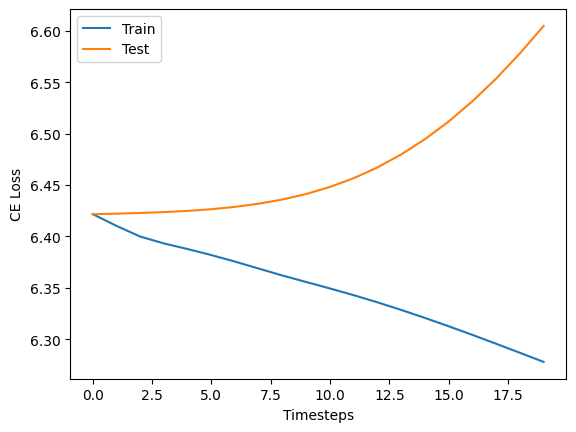

In [17]:
_ = plt.plot(hist["training_loss"], label="Train")
_ = plt.plot(hist["validation_loss"], label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("CE Loss")
_ = plt.legend()

In [18]:
_ = model.eval()

for views, purchase in test_loader:
    pred = model.predict(views.to(device))

/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_28922/580473335.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  views = torch.tensor(torch.nn.utils.rnn.pad_sequence(views, batch_first=True, padding_value=n_items))


In [19]:
from rec_baseline.metrics import get_hit_ratio, get_mrr

In [20]:
get_hit_ratio(pred, purchase)

get_mrr(pred, purchase)

0.0390625

0.02109375